# Auto encoders



![autoencoder.png](autoencoder.png)

Autoencoders encode data into a smaller representation which saves memory. Assume that large data needs to be sent From computer *A* to computer *B* over a network. Instead of sending the data in its original format, it's possible to encode using the encoder part in an autoencoder, and then reproduce the data with the decoder on computer *B*. Some information will be lost along the encode/decode process. The bottleneck layer is responsible for how how information is maintained
<br>
<br>
This project will build an autoencoder for the MNSIT dataset with two autoencoders of different size bottlenecks.

The label of the image is 8


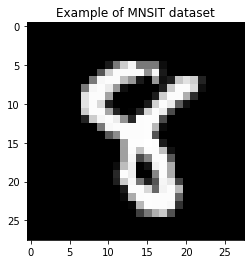

In [1]:
import torchvision.datasets as datasets
from torch import nn
from torchvision.transforms import Compose, Resize, ToTensor, ColorJitter, CenterCrop, Grayscale, Normalize
import torch.nn.functional as F
from torch import optim
import torch
from matplotlib import pyplot as plt
import numpy as np


batch_size = 8192

mnist_trainset = datasets.MNIST(root='./MNSIT', train=True, download=True, transform=Compose([Resize(size=28),
                                                                                     ToTensor()]))

mnist_testset = datasets.MNIST(root='./MNIST', train=False, download=True, transform=None)

train_dataLoader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True, num_workers=4)

images, labels = next(iter(train_dataLoader))

print("The label of the image is {}".format(labels[15]))
fig, ax = plt.subplots(figsize=(8,4))
plt.imshow(images[15].reshape(28,28), cmap="gray")
ax.set_title("Example of MNSIT dataset")

plt.show()



We will create a two networks with different bottlenecks. The input the the network will be a flattened MNSIT image $784 = 28 \times 28$.

In [2]:
class Net1(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(784, 50)
        torch.nn.init.xavier_uniform_(self.fc1.weight, gain=1.0)
        self.fc2 = nn.Linear(50, 2)
        torch.nn.init.xavier_uniform_(self.fc2.weight, gain=1.0)
        self.fc3 = nn.Linear(2, 784)
        torch.nn.init.xavier_uniform_(self.fc3.weight, gain=1.0)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x
    
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(784, 50)
        torch.nn.init.xavier_uniform_(self.fc1.weight, gain=1.0)
        self.fc2 = nn.Linear(50, 10)
        torch.nn.init.xavier_uniform_(self.fc2.weight, gain=1.0)
        self.fc3 = nn.Linear(10, 784)
        torch.nn.init.xavier_uniform_(self.fc3.weight, gain=1.0)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x
    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#loss_fn = nn.MSELoss()
loss_fn = F.mse_loss


## Training network 1

Live metrics of the MSE loss will be shown alongside an original MSNIT sample and its reproduced sample (every 50 epochs)

<IPython.core.display.Javascript object>


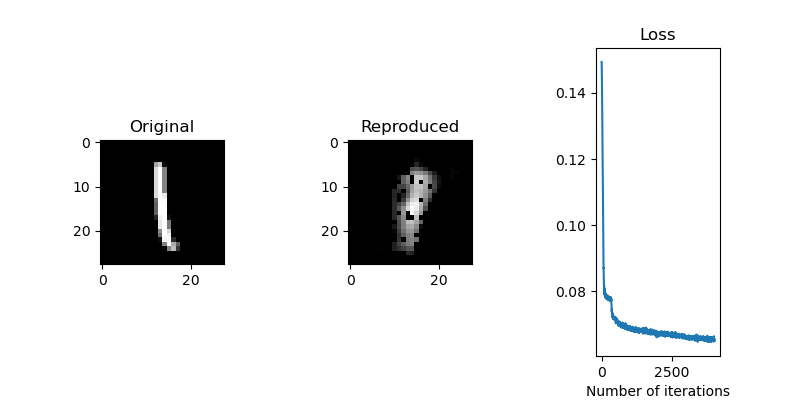

epoch number: 0
epoch number: 50
epoch number: 100
epoch number: 150
epoch number: 200
epoch number: 250
epoch number: 300
epoch number: 350
epoch number: 400
epoch number: 450


In [3]:
model = Net1()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Create figure for plotting
%matplotlib notebook
plt.ion()
fig, ax = plt.subplots(ncols=3, figsize=(8,4))
fig.subplots_adjust(wspace=1)
plot_interval = 1


# Create arrays to save all of the metrics throughout training
train_losses = []
val_losses = []
train_accs = []
val_accs = []

# Train the model
for epoch in range(500):
    if epoch%50==0:
        print("epoch number: {}".format(epoch))
    for i, (b_x, b_y) in enumerate(train_dataLoader):
        b_x, b_y = b_x.to(device), b_y.to(device)
        b_x = b_x.view(-1,784)
        target = b_x.clone()
        
        pred = model(b_x)
        
        loss = loss_fn(pred, target)
    
        # Back-propagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # Save them in the arrays
        train_losses.append(loss.item())
        
        if epoch%50==0:
            #print some output results during this epoch run
            pred = pred.cpu()
            pred = pred.detach().numpy()
            target = target.cpu()
            target = target.detach().numpy()

            
            ax[0].imshow(target[105].reshape(28,28), cmap="gray")
            ax[0].set_title('Original')
            ax[1].imshow(pred[105].reshape(28,28), cmap="gray")
            ax[1].set_title('Reproduced')
            plt.show()
        
        if i % plot_interval == 0:
            # Update plots
            ax[2].clear()
            ax[2].plot(train_losses)

            # Add legends and labels
            ax[2].set_title('Loss')
            ax[2].set_xlabel('Number of iterations')
            fig.canvas.draw()
            plt.show()
            
            
torch.save(model.state_dict(), "Net1")


## Training for autoencoder 2

<IPython.core.display.Javascript object>


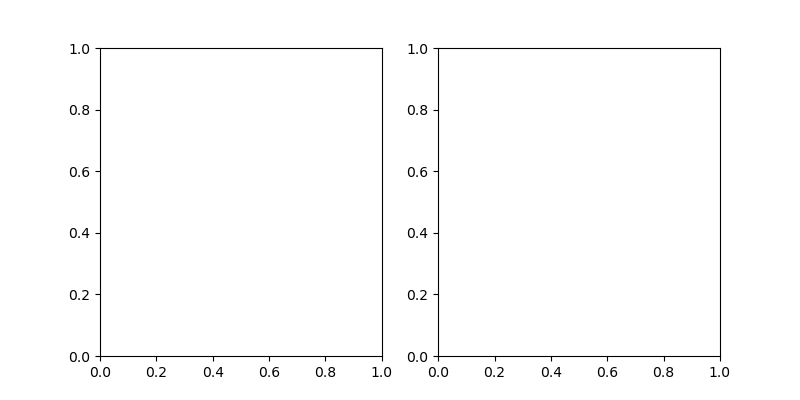

<IPython.core.display.Javascript object>


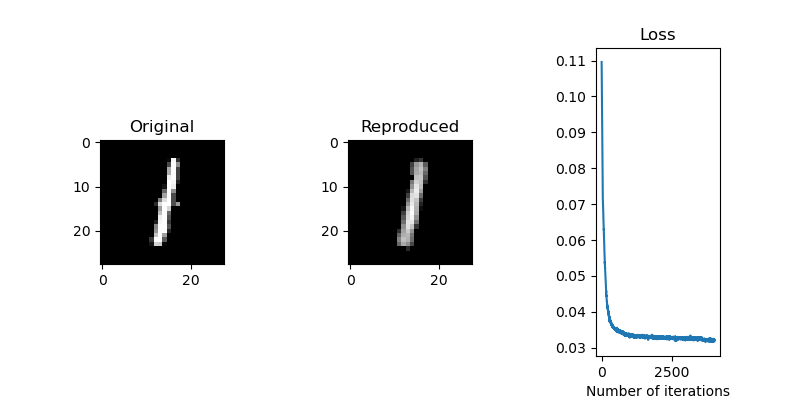

epoch number: 0
epoch number: 50
epoch number: 100
epoch number: 150
epoch number: 200
epoch number: 250
epoch number: 300
epoch number: 350
epoch number: 400
epoch number: 450


In [5]:
%matplotlib notebook
fig, ax = plt.subplots(ncols=2,figsize=(8,4))

model = Net2()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Create figure for plotting
fig, ax = plt.subplots(ncols=3,figsize=(8,4))
fig.subplots_adjust(wspace=1)
plot_interval = 1


# Create arrays to save all of the metrics throughout training
train_losses = []
val_losses = []
train_accs = []
val_accs = []

# Train the model
for epoch in range(500):
    if epoch%50==0:
        print("epoch number: {}".format(epoch))
    for i, (b_x, b_y) in enumerate(train_dataLoader):
        b_x, b_y = b_x.to(device), b_y.to(device)
        b_x = b_x.view(-1,784)
        target = b_x.clone()
        
        pred = model(b_x)
        
        loss = loss_fn(pred, target)
    
        # Back-propagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # Save them in the arrays
        train_losses.append(loss.item())
        
        if epoch%50==0:
            #print some output results during this epoch run
            pred = pred.cpu()
            pred = pred.detach().numpy()
            target = target.cpu()
            target = target.detach().numpy()

            
            ax[0].imshow(target[105].reshape(28,28), cmap="gray")
            ax[0].set_title('Original')
            ax[1].imshow(pred[105].reshape(28,28), cmap="gray")
            ax[1].set_title('Reproduced')
    
        
        if i % plot_interval == 0:
            # Update plots
            ax[2].clear()
            ax[2].plot(train_losses)

            # Add legends and labels
            ax[2].set_title('Loss')
            ax[2].set_xlabel('Number of iterations')
            fig.canvas.draw()
            
            
torch.save(model.state_dict(), "Net2")



## Results

Pick a random sample from each of the 10 digits 0-9, and show its its original and reproduced image.

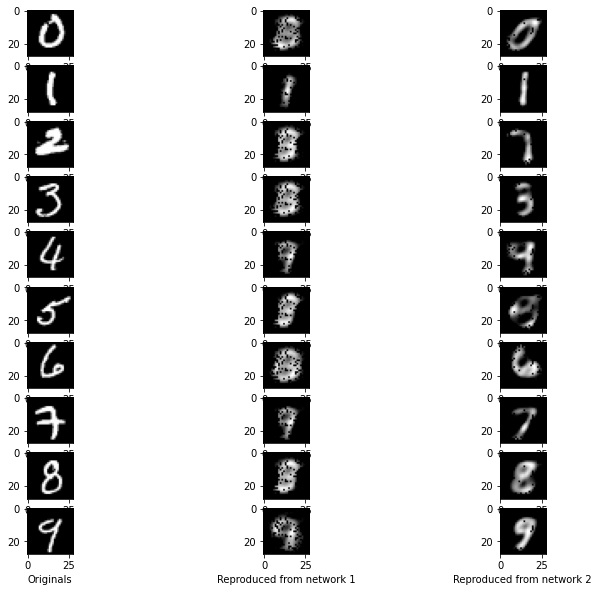

In [5]:

model1 = Net1()
model1.load_state_dict(torch.load('Net1'))
model1.to(device)

model2 = Net2()
model2.load_state_dict(torch.load('Net2'))
model2.to(device)



b_x, b_y = next(iter(train_dataLoader))
b_x, b_y = b_x.to(device), b_y.to(device)
b_x = b_x.view(-1,784)



target = b_x.clone()
pred = model1(b_x)
pred2 = model2(b_x)



# Remove objects from CUDA in order to convert them to numpy
b_y = b_y.cpu()
b_y = b_y.detach().numpy()
pred = pred.cpu()
pred = pred.detach().numpy()
pred2 = pred2.cpu()
pred2 = pred2.detach().numpy()
target = target.cpu()
target = target.detach().numpy()



fig, ax = plt.subplots(nrows=10,ncols=3, figsize=(12,10))
#fig.subplots_adjust(hspace=0.6)


rowIndex = 0
for i in range(10):
    ax[rowIndex][0].imshow(target[np.random.choice(np.where(b_y == i)[0], 1)].reshape(28,28), cmap="gray")
    ax[rowIndex][1].imshow(pred[np.random.choice(np.where(b_y == i)[0], 1)].reshape(28,28), cmap="gray")
    ax[rowIndex][2].imshow(pred2[np.random.choice(np.where(b_y == i)[0], 1)].reshape(28,28), cmap="gray")
    rowIndex += 1
    if rowIndex==9:
        ax[rowIndex][0].set_xlabel("Originals")
        ax[rowIndex][1].set_xlabel("Reproduced from network 1")
        ax[rowIndex][2].set_xlabel("Reproduced from network 2")
        
plt.show()



## Analysis autoencoder 1

Now when the training has been done, the bottleneck in Autoencoder 1 can be visualized in 2D space. We will scatter some of the values in this bottleneck for certain amount of the MNSIT samples.

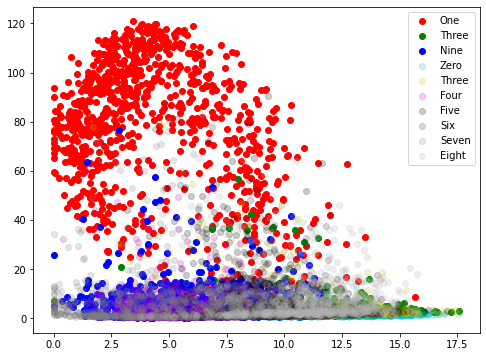

In [5]:
class Net1_encoder(Net1):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x
    
class Net1_decoder(Net1):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        x = F.relu(self.fc3(x))
        return x

model = Net1_encoder()
model.load_state_dict(torch.load('Net1'))
model.to(device)

train_dataLoader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size, 
                                               shuffle=True, num_workers=4)

b_x, b_y = next(iter(train_dataLoader))
b_x, b_y = b_x.to(device), b_y.to(device)

b_x = b_x.view(-1,784)

bottleneck = model(b_x)


# Remove objects from CUDA in order to convert them to numpy
b_y = b_y.cpu()
b_y = b_y.detach().numpy()
bottleneck = bottleneck.cpu()
bottleneck = bottleneck.detach().numpy()


fig, ax = plt.subplots(figsize=(8,6))
plt.ioff()

#Plot well reproducible digits
for digitStr,colour,digit in zip(('One','Three','Nine'),('r','g','b'),(1,3,9)):
    well_digits = bottleneck[np.where(b_y == digit)[0]]
    plt.scatter(well_digits[:,0], well_digits[:,1], c=colour, label=digitStr)

#Plot digits that don't seem well-reproducible
for digitStr,col,digit in zip(('Zero','Three','Four', 'Five', 'Six', 'Seven', 'Eight')
                                 ,('c','y','m','k',  [(.2, .2, .2)], [(.5, .5, .5)], [(.7, .7, .7)]),
                                 (0,2,4,5,6,7,8)):
    well_digits = bottleneck[np.where(b_y == digit)[0]]
    plt.scatter(well_digits[:,0], well_digits[:,1], c=col, label=digitStr, alpha=0.2)

plt.legend()
plt.show()








It can be seen from the image above that certain regions encode different digits. For example, digit *one* seems to be the most easily reproducible while the other images are mostly clustered together.The next cell tries to reproduce the digits from the encoder by using suitable values from the previous scatter plot. Digits 1,9,8 will tried to be reproduced.


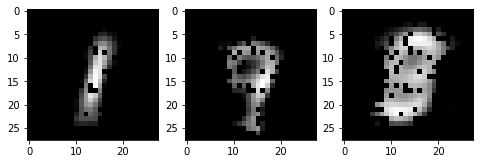

In [6]:
model = Net1_decoder()
model.load_state_dict(torch.load('Net1'))

train_dataLoader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size, 
                                               shuffle=True, num_workers=4)


# Use values here from the previous scatter plot
encoded_images = torch.tensor([[ 1., 100.],
                               [1., 10.],
                               [11., 5.,]])



images = model(encoded_images)


#Convert to numpy for imshow
images = images.detach().numpy()



#Plotting
fig, ax = plt.subplots(ncols=3, figsize=(8,6))
plt.ioff()
for i in range(3):
    ax[i].imshow(images[i].reshape(28,28), cmap="gray")

    
plt.show()
